In [96]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd

In [97]:
# utility to print any error passed
def log_error(e):
    print(e)

In [98]:
# check if the response returned is good or not
def is_good_response(resp):
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 and content_type is not None and content_type.find('html') > -1)

In [99]:
# utility to get html content from a given url
def simple_get(url):
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else :
                return None
    except RequestException as re:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None

In [100]:
# JioMart data scraping - Dals and Pulses

raw_html_dp = simple_get('https://www.jiomart.com/category/staples/dals-pulses')

# get html parsed using Beautiful soup
html_soup = BeautifulSoup(raw_html_dp, 'html.parser')

# print(html_soup)

In [101]:
containers = html_soup.findAll("div", {"class" : "col-md-3 p-0"})
# print (BeautifulSoup.prettify(containers[0]))

In [102]:
## we can write the data to a csv or json file

#filename = "JioMart_1.csv"
#f = open(filename, "w")
#headers = "Product_Name,Product_Quantity,MRP_Price,Offer_Price,Vendor,Category\n"
#f.write(headers)

In [103]:
ProductNamesList = []
ProductQtyList = []
MRP_List = []
Offer_Price_List = []
Vendor_List = []
Category_List = []

for container in containers:
    product = container.div.img["alt"]
    ProductNamesList.append(product)
    
    price_container = container.findAll("strike", {"id" : "price"})
    price = price_container[0].text.strip()
    MRP_List.append(price)
    
    final_price_container = container.findAll("span", {"id" : "final_price"})
    final_price = final_price_container[0].text.strip()
    Offer_Price_List.append(final_price)
    
    #print ("Product:" + product)
    #print ("Price:" + price)
    #print ("Final Price:" + final_price)
    
    Vendor_List.append('JioMart')
    Category_List.append('Dals-Vegetables')
    
#     print (product + "," + price + "," + final_price + ",JioMart" + ",Dals-Vegetables" +"\n")
#     f.write(product + "," + price + "," + final_price + ",JioMart" + ",Dals-Vegetables" +"\n")

    
# print('ProductNamesList =>', ProductNamesList)
# print('MRP_List =>', MRP_List)
# print('Offer_Price_List =>', Offer_Price_List)
# print('Vendor_List =>', Vendor_List)
# print('Category_List =>', Category_List)

# f.close()

In [104]:
import pandas as pd

table_dict = { 'Product_Name' : ProductNamesList,
                'MRP_Price' : MRP_List,
                'Offer_Price' : Offer_Price_List,
                'Vendor' : Vendor_List,
                'Category' : Category_List}

df = pd.DataFrame(table_dict)

df.head()

,Product_Name,MRP_Price,Offer_Price,Vendor,Category
0,Good Life Rajma Red 500 g,₹ 68.00,₹ 60.00,JioMart,Dals-Vegetables
1,Good Life Dal Mix 500 g,₹ 76.00,₹ 65.00,JioMart,Dals-Vegetables
2,Good Life Urad Washed Gota 500 g,₹ 83.00,₹ 69.00,JioMart,Dals-Vegetables
3,Good Life Tur Dal 1 kg,₹ 138.00,₹ 118.00,JioMart,Dals-Vegetables
4,Good Life Pulses Mix For Sprout 500 gm,₹ 74.00,₹ 65.00,JioMart,Dals-Vegetables


In [105]:
df.shape

(20, 5)

In [106]:
price_qty_mixed=df.Product_Name.str.split(expand=True,)
print(price_qty_mixed)
print(type(price_qty_mixed))

       0        1        2         3           4       5       6     7     8  \
0   Good     Life    Rajma       Red         500       g    None  None  None   
1   Good     Life      Dal       Mix         500       g    None  None  None   
2   Good     Life     Urad    Washed        Gota     500       g  None  None   
3   Good     Life      Tur       Dal           1      kg    None  None  None   
4   Good     Life   Pulses       Mix         For  Sprout     500    gm  None   
5     24   Mantra  Organic     Chana         Dal     500       g  None  None   
6     24   Mantra  Organic     Brown       Chana     500       g  None  None   
7   Good     Life    Rajma  Sharmili         500       g    None  None  None   
8     24   Mantra  Organic     Moong       Whole     500       g  None  None   
9     24   Mantra  Organic    Masoor         Dal     500       g  None  None   
10    24   Mantra  Organic       Raw     Peanuts     500       g  None  None   
11  Good     Life   Masoor       Dal    

In [107]:
qty_df = df.Product_Name.str.extract('(\d+)')

df['Product_Quantity'] = qty_df

In [108]:
df['Product_Name'] = df['Product_Name'].str[:16]

In [123]:
import numpy as np

newdf = df[['Product_Name', 'Product_Quantity', 'MRP_Price', 'Offer_Price', 'Vendor', 'Category']].copy()

newdf['Product_Quantity'] = pd.to_numeric(df['Product_Quantity'])

# newdf['Product_Quantity'] = newdf['Product_Quantity'].filter().div(1000)

a = np.array(newdf['Product_Quantity'].values.tolist())
# print (a)

newdf['Product_Quantity'] = np.where(a > 100, a/1000, a).tolist()

newdf['MRP_Price'] = newdf['MRP_Price'].map(lambda x: x.lstrip('₹').strip())
newdf['Offer_Price'] = newdf['Offer_Price'].map(lambda x: x.lstrip('₹').strip())

newdf.head()
newdf.describe()

newdf['MRP_Price'] = pd.to_numeric(newdf['MRP_Price'])
newdf['Offer_Price(Rs)'] = pd.to_numeric(newdf['Offer_Price'])


### Exploratory Data Analysis

In [124]:
## Observations:
## With a quick look we can observer the following:
## 1. There is one dependent variable(Y) or Response which is column 'Cost' 
## 2. There are 5 independent variables or features as Height', Width', 'Length', 'Weight', 'Weight1'
## 3. The given Regression problem is Multi-Variate Regression. 
## 4. The Linear Regression equation is of form: Y = α + β1X1 + β2X2 + β3X3
## The selection of features plays the most important role in multivariate regression

In [125]:
newdf.head()

,Product_Name,Product_Quantity,MRP_Price,Offer_Price,Vendor,Category,Offer_Price(Rs)
0,Good Life Rajma,0.5,68.0,60.00,JioMart,Dals-Vegetables,60.0
1,Good Life Dal Mi,0.5,76.0,65.00,JioMart,Dals-Vegetables,65.0
2,Good Life Urad W,0.5,83.0,69.00,JioMart,Dals-Vegetables,69.0
3,Good Life Tur Da,1.0,138.0,118.00,JioMart,Dals-Vegetables,118.0
4,Good Life Pulses,0.5,74.0,65.00,JioMart,Dals-Vegetables,65.0


In [126]:
newdf.describe()

,Product_Quantity,MRP_Price,Offer_Price(Rs)
count,20.000000,20.000000,20.000000
mean,10.010000,99.850000,88.640000
std,11.721635,39.235155,34.954826
min,0.200000,35.000000,29.000000
25%,0.500000,75.750000,65.000000
50%,1.000000,92.500000,87.875000
75%,24.000000,117.000000,95.237500
max,24.000000,200.000000,190.000000


In [127]:
newdf.shape

(20, 7)

In [128]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_Name      20 non-null     object 
 1   Product_Quantity  20 non-null     float64
 2   MRP_Price         20 non-null     float64
 3   Offer_Price       20 non-null     object 
 4   Vendor            20 non-null     object 
 5   Category          20 non-null     object 
 6   Offer_Price(Rs)   20 non-null     float64
dtypes: float64(3), object(4)
memory usage: 864.0+ bytes


In [129]:
newdf.MRP_Price.unique()

array([ 68.,  76.,  83., 138.,  74.,  85.,  75.,  55.,  90.,  80., 140.,
       120.,  98.,  95.,  35., 101., 173., 200., 116.])

In [130]:
newdf.Offer_Price.unique()

array(['60.00', '65.00', '69.00', '118.00', '80.75', '48.00', '85.50',
       '76.00', '133.00', '95.00', '93.10', '90.25', '29.00', '95.95',
       '129.00', '190.00'], dtype=object)

In [131]:
newdf.MRP_Price.value_counts()

95.0     2
116.0    1
90.0     1
76.0     1
83.0     1
138.0    1
74.0     1
85.0     1
75.0     1
55.0     1
80.0     1
200.0    1
140.0    1
120.0    1
98.0     1
35.0     1
101.0    1
173.0    1
68.0     1
Name: MRP_Price, dtype: int64

In [132]:

newdf.nunique()

Product_Name        10
Product_Quantity     4
MRP_Price           19
Offer_Price         16
Vendor               1
Category             1
Offer_Price(Rs)     16
dtype: int64

In [133]:
# check null or missing value

newdf.isnull().values.any()

False

In [138]:
## Outlier - Using Z-Score

from scipy import stats
import numpy as np

z = np.abs(stats.zscore(newdf))
print("Z-Score =>", z)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [139]:

Q1 = newdf.quantile(0.25)
Q3 = newdf.quantile(0.75)
IQR = Q3 - Q1

print("IQR:")
print(IQR)

lower_bound = Q1 -(1.5 * IQR) 
upper_bound = Q3 +(1.5 * IQR) 

print()
print("Lower bound:")
print(lower_bound)
print()
print("Upper bound:")
print(upper_bound)

IQR:
Product_Quantity    23.5000
MRP_Price           41.2500
Offer_Price(Rs)     30.2375
dtype: float64

Lower bound:
Product_Quantity   -34.75000
MRP_Price           13.87500
Offer_Price(Rs)     19.64375
dtype: float64

Upper bound:
Product_Quantity     59.25000
MRP_Price           178.87500
Offer_Price(Rs)     140.59375
dtype: float64


In [140]:
## removing Outliers using IQR
def remove_outlier(df, low, high):
    #low = .05
    #high = .95
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
#         if is_numeric_dtype(lugg_df[name]):
        df = df[(df[name] > quant_df.loc[low, name]) 
        & (df[name] < quant_df.loc[high, name])]
    return df

In [141]:
# After removing outliers using Z-Score calculated above
newdf = newdf[(z < 3).all(axis=1)]
newdf.shape

NameError: name 'z' is not defined

In [143]:
## Finding Correlation and depicting using Heat Map

import seaborn as sb

correlation_matrix = np.corrcoef(newdf)
print("Correlation Matrix:")
print("Correlation of Cost with Weight:", correlation_matrix[0,1])
print("Correlation of Cost with Volume:", correlation_matrix[0,2])
sb.heatmap(data=correlation_matrix, annot=True)

TypeError: can only concatenate str (not "float") to str

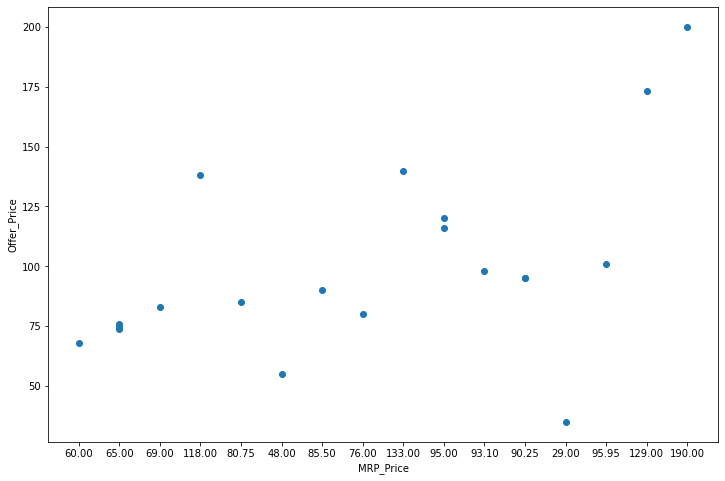

In [146]:
# Finding Correlation between Cost and Weight
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(figsize=(12, 8))
ax.scatter(newdf['Offer_Price'], newdf['MRP_Price'])
ax.set_xlabel('MRP_Price')
ax.set_ylabel('Offer_Price')
plt.show()

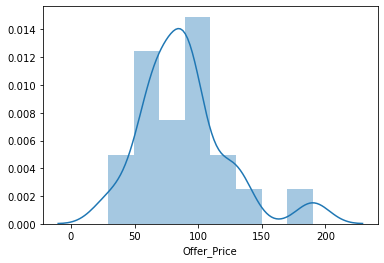

In [147]:
## Distribution Plot for Cost (the dependent variable)
sb.distplot(newdf['Offer_Price'])

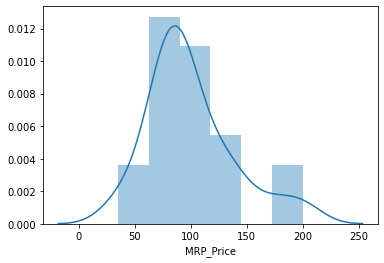

In [148]:
## Distribution Plot for Cost (the dependent variable)
sb.distplot(newdf['MRP_Price'])

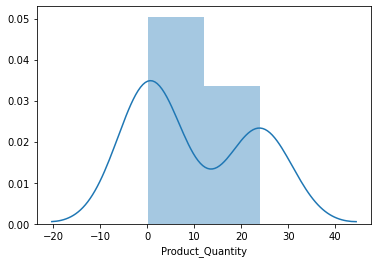

In [149]:
## Distribution Plot for Cost (the dependent variable)
sb.distplot(newdf['Product_Quantity'])